# Makes plots for the visual model network-network comparisons. 

The predictions of a given model for metamers generated from the other models are in the `network_network_evaluations` folder of each directory. This notebook pulls in the data from those network-network comparisons and plots them, and also compares the network responses to the human responses for each layer. 

In [1]:
import numpy as np
import pandas as pd
import os 
import glob
import math
import json
import scipy
import scipy.stats
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib
import pickle as pckl
from PIL import Image
import seaborn as sns

import urllib.request, json
from scipy.io import loadmat

import sys
from model_analysis_folders import all_model_info

from notebooks.notebook_helpers import responses_network_by_layer_mat, combined_experiment_response_dictionaries, unpack_experiment_mat

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams.update({'font.size': 6})



In [2]:
from model_analysis_folders import all_model_info
from model_analysis_folders import color_model_info

all_networks_and_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES

models_to_evaluate = color_model_info.visual_models_to_plot

# These models were not given specific colors/line styles, so we add them here. 
if 'alexnet_early_checkpoint' not in models_to_evaluate:
    extra_models = ["alexnet_early_checkpoint", 
                    "alexnet_reduced_aliasing_early_checkpoint",
                    "vonealexnet_gaussian_noise_std4_fixed"]
    models_to_evaluate.extend(extra_models)

network_network_folder = 'network_network_evaluations'


In [3]:
models_by_type = {'cornet_s':'standard',
              'alexnet':'standard',
              'vgg_19':'standard',
              'resnet50':'standard',
              'resnet101':'standard',
              'resnet50_simclr':'contrastive',
              'resnet50_moco_v2':'contrastive',
              'resnet50_byol':'contrastive',
              'resnet50_l2_3_robust':'adv_trained',
              'resnet50_linf_4_robust':'adv_trained',
              'resnet50_linf_8_robust':'adv_trained',
              "resnet50_random_l2_perturb":'rand_trained',
              "resnet50_random_linf8_perturb":'rand_trained',
              'alexnet_l2_3_robust':'adv_trained',
              'alexnet_linf_8_robust':'adv_trained',
              "alexnet_random_l2_3_perturb":'rand_trained',
              "alexnet_random_linf8_perturb":'rand_trained',
              "alexnet_early_checkpoint":'other',
              "alexnet_reduced_aliasing_early_checkpoint":'other',
              "vonealexnet_gaussian_noise_std4_fixed":'other',
              'texture_shape_resnet50_trained_on_SIN':"shape_trained", 
              'texture_shape_alexnet_trained_on_SIN':"shape_trained", 
              'CLIP_resnet50':"large_dataset", 
              'CLIP_ViT-B_32':"large_dataset",
              'SWSL_resnet50':"large_dataset",
              'SWSL_resnext101_32x8d':"large_dataset",
              'vision_transformer_vit_large_patch16_224':"large_dataset",
              'konkle_alexnetgn_ipcl_ref01_primary_model':"ipcl",
              'konkle_alexnetgn_ipcl_ref12_supervised_ipcl_aug':"ipcl",
             }

models_by_name = {'cornet_s':'CORnet-S \n Standard',
              'alexnet':'AlexNet \n Standard',
              'vgg_19':'VGG-19 \n Standard',
              'resnet50':'ResNet50 \n Standard',
              'resnet101':'ResNet101 \n Standard',
              'resnet50_simclr':'ResNet50 \n SimCLR',
              'resnet50_moco_v2':'ResNet50 \n MoCo_V2',
              'resnet50_byol':'ResNet50 \n BYOL',
              'resnet50_l2_3_robust':'ResNet50 \n L2-norm (ε=3)',
              'resnet50_linf_4_robust':'ResNet50 \n L∞-norm (ε=4/255)',
              'resnet50_linf_8_robust':'ResNet50 \n L∞-norm (ε=8/255)',
              "resnet50_random_l2_perturb":'ResNet50 \n random L2-norm (ε=3)',
              "resnet50_random_linf8_perturb":'ResNet50 \n random L∞-norm (ε=8/255)',
              'alexnet_l2_3_robust':'AlexNet\n L2-norm (ε=3)',
              'alexnet_linf_8_robust':'AlexNet \n L∞-norm (ε=8/255)',
              "alexnet_random_l2_3_perturb":'AlexNet \n random  L2-norm (ε=3)',
              "alexnet_random_linf8_perturb":'AlexNet \n random L∞-norm (ε=8/255)',
              "alexnet_early_checkpoint":'AlexNet \n Early Checkpoint',
              "alexnet_reduced_aliasing_early_checkpoint":'LowpassAlexNet \n Early Checkpoint',
              "vonealexnet_gaussian_noise_std4_fixed":'VOneAlexNet \n std=4',
              'texture_shape_resnet50_trained_on_SIN':"ResNet50 \n Stylized ImageNet", 
              'texture_shape_alexnet_trained_on_SIN':"AlexNet \n Stylized ImageNet", 
              'CLIP_resnet50':"ResNet50 \n CLIP", 
              'CLIP_ViT-B_32':"ViT-B_32 \n CLIP",
              'SWSL_resnet50':"ResNet50 \n SWSL",
              'SWSL_resnext101_32x8d':"ResNext101_32x8d \n SWSL",
              'vision_transformer_vit_large_patch16_224':"ViT-L-Patch16_224",
              'konkle_alexnetgn_ipcl_ref01_primary_model':"AlexNetGN \n IPCL Primary Model",
              'konkle_alexnetgn_ipcl_ref12_supervised_ipcl_aug':"AlexNetGN \n IPCL Supervised Comparison",                  
             }

model_types = ['standard','contrastive','adv_trained','rand_trained', 'other',
               'shape_trained','large_dataset','ipcl']

## Supplementary Figure 3
### Plots for each generation model of individual recognition model performance curves. 

Note: This loads in the data for the summary plots below. 


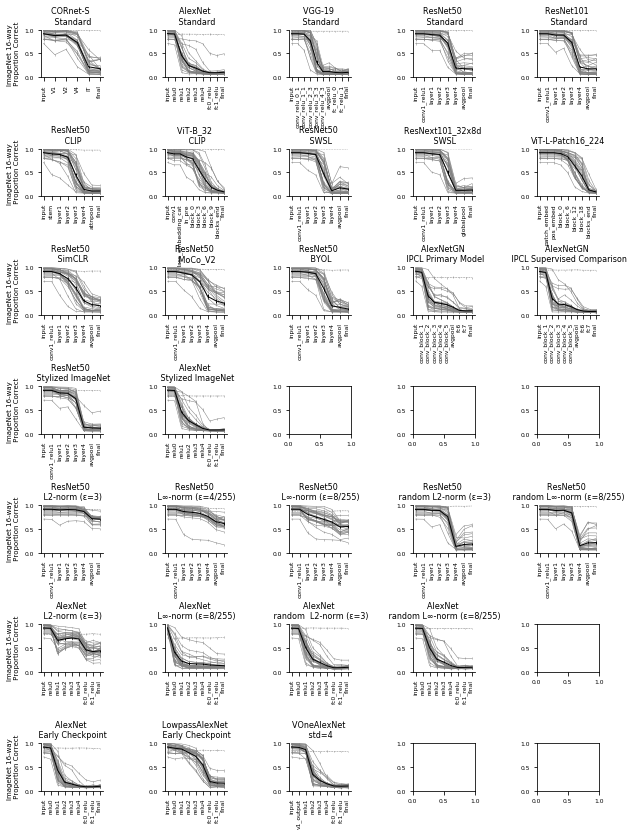

In [4]:
# Raw data -- all models. 16 way predictions because that is what the humans did (and this is how we validated the metamers)
model_types = ['standard','contrastive','adv_trained','rand_trained', 'other',
               'shape_trained','large_dataset','ipcl']

# Goal -- store the predictions for each model-layer pair. 
# Plot everything as we go just so we see what we are doing... 

# Different plot numbering here to account for the new paper ordering.
plot_num = [0,0,
            0,0,0, 
            2,2,2,
            4,4,4,
            4,4,
            5,5,
            5,5,
            3,3,
            1,1,1,1,1,
            2,2,
            6,6,6,
            ] 

current_column_dict = {n:0 for n in set(plot_num)}
subplot_idx=0
num_rows = max(np.array(plot_num))+1
num_columns = 5
fig, axs = plt.subplots(num_rows, num_columns, figsize=(2*num_columns,2*num_rows),
                        gridspec_kw={'hspace': 1.5, 'wspace': 1})

all_other_nets_evals = {}

# These will group together the MEASUREMENTS from a given model type. 
all_other_nets_evals_by_type = {}

for met_mod_idx, metamer_model in enumerate(models_to_evaluate):
    current_row = plot_num[met_mod_idx]
    current_column = current_column_dict[current_row]
    
    all_other_nets_evals[metamer_model] = {}
    all_other_nets_evals_by_type[metamer_model] = {}
    metamer_model_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[metamer_model]['layers']
    for layer in metamer_model_layers:
        all_other_nets_evals[metamer_model][layer] = []
        all_other_nets_evals_by_type[metamer_model][layer] = {m_type:[] for m_type in model_types}
    for measured_model in models_to_evaluate:
        measured_model_info = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[measured_model]
        pckl_path = os.path.join(measured_model_info['location'], network_network_folder, 'accuracy_on_metamers_from_%s.pckl'%metamer_model)
        try:
            eval_pckl = pckl.load(open(pckl_path, 'rb'))
        except FileNotFoundError:
            print('Missing %s'%pckl_path)
        # Store the data here. 
        for layer in metamer_model_layers:
            if measured_model!=metamer_model:
                all_other_nets_evals[metamer_model][layer].append(eval_pckl['average_correct_16'][layer])
                all_other_nets_evals_by_type[metamer_model][layer][models_by_type[measured_model]].append(eval_pckl['average_correct_16'][layer])
        if measured_model==metamer_model:
            this_plot_linestyle = '--'
        else:
            this_plot_linestyle = '-'
        axs[current_row, current_column].errorbar(range(len(metamer_model_layers)), 
                 [eval_pckl['average_correct_16'][layer] for layer in metamer_model_layers],
                     yerr=[eval_pckl['bootstrap_sem_16'][layer] for layer in metamer_model_layers],
                 color='grey', 
                 linewidth=0.5,
                 ls=this_plot_linestyle) 
    # plot the average
    axs[current_row, current_column].errorbar(range(len(metamer_model_layers)), 
             [np.mean(np.array(all_other_nets_evals[metamer_model][layer])) for layer in metamer_model_layers],
                 yerr=[np.std(np.array(all_other_nets_evals[metamer_model][layer]))/np.sqrt(len(all_other_nets_evals[metamer_model][layer])) for layer in metamer_model_layers],
             color='k', 
             linewidth=1,
             ls='-')
    
    axs[current_row, current_column].set_title(models_by_name[metamer_model], fontsize=8)
    axs[current_row, current_column].set_ylim([0,1])
    if current_column==0:
        axs[current_row, current_column].set_ylabel('ImageNet 16-way \n Proportion Correct', fontsize=7)
    axs[current_row, current_column].set_xticks(range(len(metamer_model_layers)))
    axs[current_row, current_column].set_xticklabels(labels=[layer.split('_fake_relu')[0].split('_after_preproc')[0] for layer in metamer_model_layers], rotation=90, fontsize=6)
    # Hide the right and top spines
    axs[current_row, current_column].spines['right'].set_visible(False)
    axs[current_row, current_column].spines['top'].set_visible(False)

    current_column_dict[current_row]+=1

plt.savefig('vision_model_model_comparisons.pdf')


### Load in the human performance.

In [5]:
experiment_list = [1,5,3,4,9,10,12,16] # Experiments included in this analysis. 
all_experiment_dictionaries = []

for exp_num in experiment_list:
    experiment_name = all_model_info.TURK_IMAGE_EXPERIMENTS_GROUPINGS['experiment_%d'%exp_num]['paper_experiment_name']
    jsin_configs = all_model_info.TURK_IMAGE_EXPERIMENTS_GROUPINGS['experiment_%d'%exp_num]['experiment_params_web']

    with urllib.request.urlopen(jsin_configs) as url:
        experiment_params = json.loads(url.read().decode())

    plot_model_order = experiment_params['experiment_info']['networks']
    
    exp_response_dict = {}
    for n_idx, network in enumerate(experiment_params['experiment_info']['networks']):
        participant_data_matrix, model_layers, conditions, participants = unpack_experiment_mat(
            '../VisionBehavioralExperiments/EXP%d_ANALYSIS/VisionExperiment%d_network_vs_humans_datamatrix_%s_public.mat'%(exp_num, exp_num, network))
        exp_response_dict[network] = responses_network_by_layer_mat(participant_data_matrix, model_layers, conditions, experiment_params)

    all_experiment_dictionaries.append(exp_response_dict)

combined_experiment_dict = combined_experiment_response_dictionaries(all_experiment_dictionaries)


# Visual Model-Human Recognizability Scatter Plot
# Figure 8E

R^2=0.897, p=0.000
rho=0.938, p=0.000
tau=0.783, p=0.000


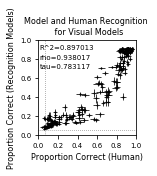

In [6]:
matplotlib.rcParams.update({'font.size': 7})

combined_human_means = []
combined_human_sem = []
combined_model_means = []
combined_model_sem = []

for model in combined_experiment_dict.keys():
    for layer in all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[model]['layers']:
        if ('input_after_preproc' not in layer):
            human_average = np.mean(combined_experiment_dict[model][layer])
            human_sem = np.std(combined_experiment_dict[model][layer])/np.sqrt(len(combined_experiment_dict[model][layer]))
            
            other_models_average = np.mean(all_other_nets_evals[model][layer])
            other_models_sem = np.std(all_other_nets_evals[model][layer])/np.sqrt(len(all_other_nets_evals[model][layer]))
            
            combined_human_means.append(human_average)
            combined_human_sem.append(human_sem)
            
            combined_model_means.append(other_models_average)
            combined_model_sem.append(other_models_sem)
    
plt.figure(figsize=(1.75,1.75))
plt.errorbar(combined_human_means, 
             combined_model_means,
             fmt='.',
             xerr=combined_human_sem,
             yerr=combined_model_sem,
             color='k',
             linewidth=0.75,
             markersize=2)
plt.plot([1/16,1/16],[0,1],':',color='grey', linewidth=0.75)
plt.plot([0,1],[1/16,1/16],':',color='grey', linewidth=0.75)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Proportion Correct (Human)', fontsize=8)
plt.ylabel('Proportion Correct (Recognition Models)', fontsize=8)
plt.title('Model and Human Recognition \n for Visual Models', fontsize=8)

import scipy.stats
r_value, p_value = scipy.stats.pearsonr(combined_human_means, combined_model_means)
print('R^2=%0.3f, p=%0.3f'%(r_value**2, p_value))
plt.text(0.01,0.9,'R^2=%f'%r_value**2, fontsize=7)

# Note: in our paper we just report the spearman correlation, but other stats are 
# included here for completeness (all are significant)
rho_value, p_value = scipy.stats.spearmanr(combined_human_means, combined_model_means)
print('rho=%0.3f, p=%0.3f'%(rho_value, p_value))
plt.text(0.01,0.8,'rho=%f'%rho_value, fontsize=7)

tau_value, p_value = scipy.stats.kendalltau(combined_human_means, combined_model_means)
print('tau=%0.3f, p=%0.3f'%(tau_value, p_value))
plt.text(0.01,0.7,'tau=%f'%tau_value, fontsize=7)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

# plt.savefig('ScatterModelHumanVisualModels.pdf')

# Change back for the other plots in this notebook
matplotlib.rcParams.update({'font.size': 6})



# Average Visual ResNet50 plot
# Figure 8B

([<matplotlib.axis.XTick at 0x2b6965299970>,
 <a list of 8 Text xticklabel objects>)

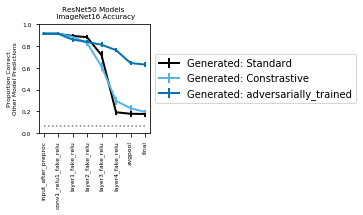

In [7]:
plt.figure(figsize=(2,2))
all_group_data = {}

model_groupings = {'Generated: Standard':['resnet50'],
                   'Generated: Constrastive':['resnet50_simclr', 'resnet50_moco_v2', 'resnet50_byol'],
                   'Generated: adversarially_trained':['resnet50_l2_3_robust', 'resnet50_linf_4_robust', 'resnet50_linf_8_robust'],
                  }

color_standard = 'k'
color_contrastive = (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)
color_adv = (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)

color_dict = {'Generated: Standard':color_standard,
               'Generated: Constrastive':color_contrastive,
               'Generated: adversarially_trained':color_adv,
              }

for group_idx, metamer_group in enumerate(model_groupings.keys()):
    all_group_data[metamer_group] = {}
    for met_mod_idx, metamer_model in enumerate(model_groupings[metamer_group]):
        all_group_data[metamer_group][metamer_model] = {}
        if (group_idx==0) and (met_mod_idx==0):
            metamer_model_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[metamer_model]['layers']
        else:
            # For this type of plot, the layers need to be *exactly* the same between the models. 
            assert metamer_model_layers == all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[metamer_model]['layers']
        for measured_model in models_to_evaluate:
            if measured_model != metamer_model:
                measured_model_info = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[measured_model]
                pckl_path = os.path.join(measured_model_info['location'], network_network_folder, 'accuracy_on_metamers_from_%s.pckl'%metamer_model)
                eval_pckl = pckl.load(open(pckl_path, 'rb'))
                average_correct = [eval_pckl['average_correct_16'][layer] for layer in metamer_model_layers]
                # Save the average group data. We will do the plotting afterwards. 
                all_group_data[metamer_group][metamer_model][measured_model] = average_correct

    # First average across the metamer generation models
    average_data_from_group = {}
    for measured_model in models_to_evaluate:
        collapse_data = []
        for metamer_model in model_groupings[metamer_group]:
            if measured_model != metamer_model:
                collapse_data.append(all_group_data[metamer_group][metamer_model][measured_model])
        if len(model_groupings[metamer_group])>1:
            average_data_from_group[measured_model] = np.mean(np.array(collapse_data),0)
        else:
            if measured_model == model_groupings[metamer_group][0]:
                average_data_from_group[measured_model] = np.ones((len(metamer_model_layers)))*np.nan
            else:
                average_data_from_group[measured_model] = np.squeeze(np.array(collapse_data))
    
    average_over_all_measured_models = np.squeeze(np.nanmean(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0))
    sem_over_all_measured_models = np.squeeze(np.nanstd(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0)/np.sqrt(len(models_to_evaluate)-1)) # N-1 because we don't use the same model for predictions
    plt.errorbar(range(len(metamer_model_layers)),
                 average_over_all_measured_models, 
                 yerr=sem_over_all_measured_models,
                 linewidth=2,
                 label=metamer_group,
                 color = color_dict[metamer_group]
                 )
    
plt.plot([0,len(metamer_model_layers)-1],[1/16,1/16],':',color='grey')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.title('ResNet50 Models \n ImageNet16 Accuracy')
plt.ylim([0,1])
plt.ylabel('Proportion Correct\n Other Model Predictions')
plt.xticks(range(len(metamer_model_layers)), metamer_model_layers, rotation=90)
          
# plt.savefig('ResNetGroupFourModelTypesModelModelComparisons.pdf')

# Experiment 9 (LowpassAlexNet and VOneAlexNet) Average Plots

In [8]:
model_groupings = {'Standard AlexNet\n(Figure 6d-h checkpoint)':['alexnet_early_checkpoint'],
                   'LowpassAlexNet':['alexnet_reduced_aliasing_early_checkpoint'],
                   'VOneAlexNet':['vonealexnet_gaussian_noise_std4_fixed'],
                   # 'Generated: random_perturbations':["resnet50_random_l2_perturb", "resnet50_random_linf8_perturb"]
                  }

group_colors = ['k', sns.color_palette("colorblind")[1], sns.color_palette("colorblind")[2]]


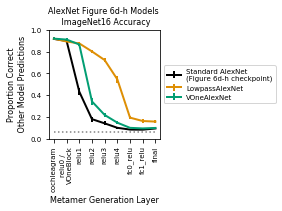

In [9]:
matplotlib.rcParams.update({'font.size': 7})

plt.figure(figsize=(2,2))
all_group_data = {}

import seaborn as sns


layer_names = ['cochleagram',
              'relu0 /\nVOneBlock',
              'relu1',
              'relu2',
              'relu3',
              'relu4',
              'fc0_relu',
              'fc1_relu',
              'final'
              ]

for group_idx, metamer_group in enumerate(model_groupings.keys()):
    all_group_data[metamer_group] = {}
    for met_mod_idx, metamer_model in enumerate(model_groupings[metamer_group]):
        all_group_data[metamer_group][metamer_model] = {}
        # if (group_idx==0) and (met_mod_idx==0):
        metamer_model_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[metamer_model]['layers']
        for measured_model in models_to_evaluate:
            if measured_model != metamer_model:
                measured_model_info = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[measured_model]
                pckl_path = os.path.join(measured_model_info['location'], network_network_folder, 'accuracy_on_metamers_from_%s.pckl'%metamer_model)
                eval_pckl = pckl.load(open(pckl_path, 'rb'))
                average_correct = [eval_pckl['average_correct_16'][layer] for layer in metamer_model_layers]
                # Save the average group data. We will do the plotting afterwards. 
                all_group_data[metamer_group][metamer_model][measured_model] = average_correct

    # First average across the metamer generation models
    average_data_from_group = {}
    for measured_model in models_to_evaluate:
        collapse_data = []
        for metamer_model in model_groupings[metamer_group]:
            if measured_model != metamer_model:
                collapse_data.append(all_group_data[metamer_group][metamer_model][measured_model])
        if len(model_groupings[metamer_group])>1:
            average_data_from_group[measured_model] = np.mean(np.array(collapse_data),0)
        else:
            if measured_model == model_groupings[metamer_group][0]:
                average_data_from_group[measured_model] = np.ones((len(metamer_model_layers)))*np.nan
            else:
                average_data_from_group[measured_model] = np.squeeze(np.array(collapse_data))
    
    average_over_all_measured_models = np.squeeze(np.nanmean(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0))
    sem_over_all_measured_models = np.squeeze(np.nanstd(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0)/np.sqrt(len(models_to_evaluate)-1)) # N-1 because we don't use the same model for predictions
    plt.errorbar(range(len(metamer_model_layers)),
                 average_over_all_measured_models, 
                 yerr=sem_over_all_measured_models,
                 linewidth=2,
                 label=metamer_group,
                 color = group_colors[group_idx]
                 )

plt.plot([0,len(metamer_model_layers)-1],[1/16,1/16],':',color='grey')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)
plt.title('AlexNet Figure 6d-h Models \n ImageNet16 Accuracy', fontsize=8)
plt.ylim([0,1])
plt.ylabel('Proportion Correct\n Other Model Predictions', fontsize=8)
plt.xticks(range(len(metamer_model_layers)), layer_names, rotation=90)
plt.xlabel('Metamer Generation Layer', fontsize=8)    

# plt.savefig('Exp9LowpassAndVoneNetModelModelComparisons.pdf')

matplotlib.rcParams.update({'font.size': 6})
